In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(1024)

In [3]:
volume = tifffile.imread(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon2\recon_fused_tp_60_ch_0.tif")
save_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon")

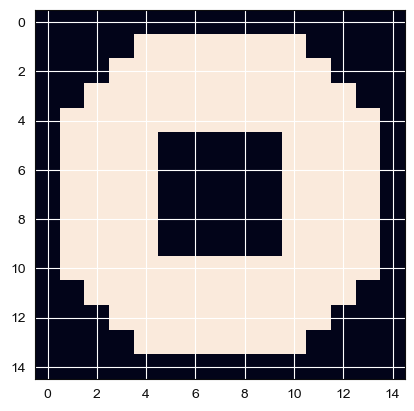

In [27]:
# from skimage.morphology import ball
# 
# sz1 = 3
# sz2 = 7
# 
# selem1 = ball(sz1)
# selem2 = ball(sz2)
# 
# n = sz2 - sz1
# selem1 = np.pad(selem1, (n, n), mode="constant", constant_values=0)
# 
# h_ball = selem2 - selem1
# 
# plt.imshow(h_ball[8])
# plt.show()
# 
# def h_ball_filter(vol):
#     return np.mean()

232.0445 -67.46524 0.020828862


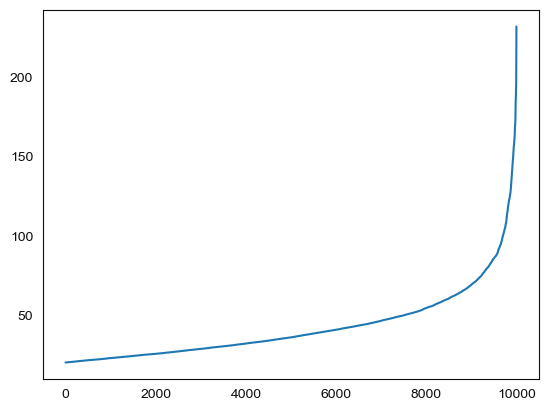

<Points layer 'pts' at 0x201eacaea10>

In [7]:
from skimage.filters import difference_of_gaussians, threshold_local
from skimage.feature import peak_local_max
from scipy.ndimage import convolve
import napari

# lt = volume - threshold_local(volume, 25)
v = difference_of_gaussians(volume, 2, 6)
# v = dog - lt
# v = difference_of_gaussians(volume, 3, 8)
print(v.max(), v.min(), v.mean())
pts = peak_local_max(v, min_distance=2, threshold_abs=20)
vals = v[pts[:, 0], pts[:, 1], pts[:, 2]]
plt.plot(sorted(vals))
plt.show()
viewer = napari.Viewer()
viewer.add_image(volume)
viewer.add_image(v)
# viewer.add_image(lt)
# viewer.add_image(dog)
viewer.add_points(pts, text=[str(l) for l in vals], size=10, out_of_slice_display=True)

In [11]:
from scipy.spatial import ConvexHull, Delaunay

hull = ConvexHull(pts)

[np.array([hull.points[p] for p in simplex]) for simplex in hull.simplices]

[array([[123.,  10., 192.],
        [144.,  11., 183.],
        [137.,  33.,  32.]]),
 array([[  9.,  20., 343.],
        [ 26., 194., 180.],
        [  9.,   4., 349.]]),
 array([[  9.,  20., 343.],
        [ 24., 240., 183.],
        [ 26., 194., 180.]]),
 array([[357., 261., 349.],
        [191., 653., 316.],
        [ 12., 564., 349.]]),
 array([[357., 261., 349.],
        [191., 653., 316.],
        [199., 668., 312.]]),
 array([[184., 675., 313.],
        [191., 653., 316.],
        [ 12., 564., 349.]]),
 array([[184., 675., 313.],
        [191., 653., 316.],
        [199., 668., 312.]]),
 array([[145., 543.,  26.],
        [139., 571.,  28.],
        [137.,  33.,  32.]]),
 array([[256., 434.,  40.],
        [251., 351.,  45.],
        [274., 429.,  51.]]),
 array([[206., 462.,  23.],
        [137.,  33.,  32.],
        [176., 483.,  21.]]),
 array([[206., 462.,  23.],
        [223., 436.,  27.],
        [137.,  33.,  32.]]),
 array([[110.,  13., 184.],
        [  9.,   4., 349.]

In [246]:
from collections import Counter

import napari


# viewer = napari.Viewer(ndisplay=3)
# viewer.window.resize(2000, 2000)
# viewer.add_image(volume, name='volume', scale=(1, 1, 1))

viewer = napari.view_image(volume, name='volume', scale=(1, 1, 1), ndisplay=3, rotate=(15, 0, 90))

# You can do anything you would normally do with the viewer object
# like take a
screenshot = viewer.screenshot(path=save_path / "screenshot.png", canvas_only=True)
viewer.close()


C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\napari\layers\utils\_slice_input.py:189: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\napari\layers\utils\_slice_input.py:189: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\napari\layers\utils\_slice_input.py:189: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(


In [202]:
from numba import jit
from math import floor
@jit(nopython=True, cache=True)
def raycast(volume, ray_origin, ray_direction, t_firsts, t_lasts, t_lowest, t_highest, count, attenuation=0.01):
    out = np.zeros(len(ray_origin))

    for r in range(len(ray_origin)):
        if t_firsts[r] > t_lasts[r]:
            continue

        t_vals = []
    
        for d in range(3):
            if ray_direction[d] != 0:
                start = min(t_lowest[r, d], t_highest[r, d])
                end = max(t_lowest[r, d], t_highest[r, d])
                num = int(count[r, d])
                if num <= 1:
                    continue
                t_vals.extend([start + i * (end - start) / (num - 1) for i in range(num)])
        
        if len(t_vals) == 0:
            continue
    
        t_vals = np.array(t_vals)
        for t in t_vals:
            pos = ray_origin[r] + t * ray_direction
            pos = np.floor(pos).astype(np.int32)
            if (0 <= pos[2] < volume.shape[0] and
                0 <= pos[1] < volume.shape[1] and
                0 <= pos[0] < volume.shape[2]):
                v = volume[pos[2], pos[1], pos[0]]
                
                v = v * np.exp(-attenuation * (t - t_firsts[r]))
                
                if v > out[r]:
                    out[r] = v
       
    return out

In [203]:
from scipy.spatial.transform import Rotation as R

volume_centroid = np.array([volume.shape[i]/2 for i in [2, 1, 0]])
print(volume_centroid)
# camera view is orthogonal (no perspective)
camera_shape = (400, 900)
camera_scale = 1
camera_distance = 1000
camera_roll = 0
camera_pitch = 45
camera_yaw = 0

rot = R.from_euler("XYZ", [camera_roll, camera_pitch, camera_yaw], degrees=True)
rot_mat = rot.as_matrix()

ray_px_x, ray_px_y = np.meshgrid(np.arange(camera_shape[0]), np.arange(camera_shape[1]), indexing="ij")
print(ray_px_x.shape)
ray_px_x = ray_px_x - camera_shape[0]//2
ray_px_y = ray_px_y - camera_shape[1]//2

ray_origin = np.ones((camera_shape[0], camera_shape[1], 3)) * np.array([0, 0, camera_distance])
ray_origin[..., 0] = ray_px_x * camera_scale
ray_origin[..., 1] = ray_px_y * camera_scale
ray_origin = rot.apply(ray_origin.reshape(-1, 3))
ray_origin += np.array(volume_centroid)
ray_direction = rot.apply([0, 0, -1])
print(ray_direction)

t_mins = (np.array([0, 0, 0]) - ray_origin) / ray_direction
t_maxs = (np.array(volume.shape[::-1]) - 1 - ray_origin) / ray_direction
# remove zero dimensions
t_mins = t_mins[..., ray_direction != 0]
t_maxs = t_maxs[..., ray_direction != 0]
t_firsts = np.max(np.minimum(t_mins, t_maxs), axis=-1)
t_lasts = np.min(np.maximum(t_mins, t_maxs), axis=-1)
print(t_firsts)

pos_start = ray_origin + t_firsts[..., None] * ray_direction
pos_end = ray_origin + t_lasts[..., None] * ray_direction

lowest = np.ceil(np.minimum(pos_start, pos_end))
highest = np.floor(np.maximum(pos_start, pos_end))
count = highest - lowest
t_lowest = (lowest - ray_origin) / ray_direction
t_highest = (highest - ray_origin) / ray_direction

min_val = 500

out = raycast(volume, ray_origin, ray_direction, t_firsts, t_lasts, t_lowest, t_highest, count)

[183.  449.5 192.5]
(400, 900)
[-0.70710678  0.         -0.70710678]
[929.17810281 929.17810281 929.17810281 ... 941.61313165 941.61313165
 941.61313165]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_18420\1970137950.py:29: RuntimeWarning: divide by zero encountered in divide
  t_mins = (np.array([0, 0, 0]) - ray_origin) / ray_direction
C:\Users\Harrison\AppData\Local\Temp\ipykernel_18420\1970137950.py:30: RuntimeWarning: divide by zero encountered in divide
  t_maxs = (np.array(volume.shape[::-1]) - 1 - ray_origin) / ray_direction
C:\Users\Harrison\AppData\Local\Temp\ipykernel_18420\1970137950.py:44: RuntimeWarning: divide by zero encountered in divide
  t_lowest = (lowest - ray_origin) / ray_direction
C:\Users\Harrison\AppData\Local\Temp\ipykernel_18420\1970137950.py:45: RuntimeWarning: divide by zero encountered in divide
  t_highest = (highest - ray_origin) / ray_direction


0.0 1168.2454144673507


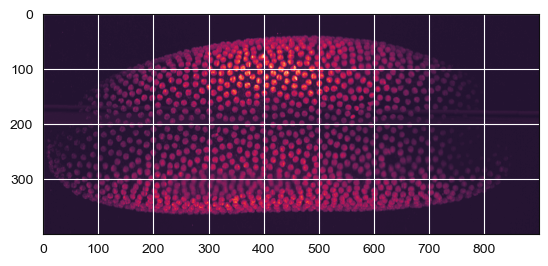

In [204]:
out = np.array(out)
out = out.reshape(camera_shape)
plt.imshow(out)
print(out.min(), out.max())
tifffile.imwrite(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\test.tif", out)


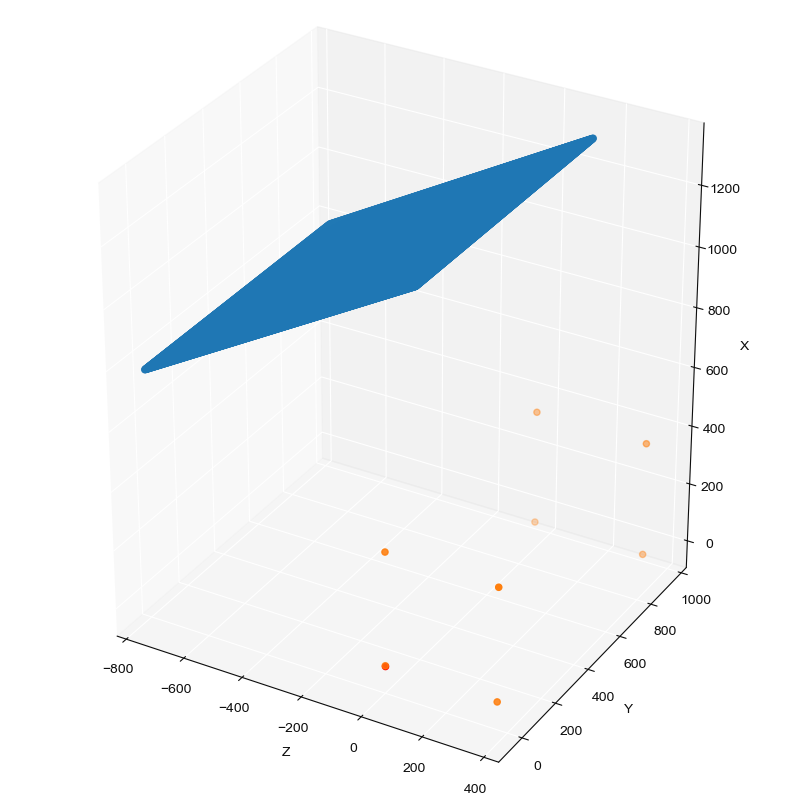

In [67]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([0], [0], [0], c="r")
ax.scatter(ray_origin[..., 0], ray_origin[..., 1], ray_origin[..., 2])
pts = []
for x in [0, volume.shape[2]]:
    for y in [0, volume.shape[1]]:
        for z in [0, volume.shape[0]]:
            pts.append([x, y, z])
pts = np.array(pts)
ax.scatter(pts[..., 0], pts[..., 1], pts[..., 2])
ax.set_aspect("equal")
ax.set_zlabel("X")
ax.set_ylabel("Y")
ax.set_xlabel("Z")
plt.show()